In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import pandas as pd
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import skimage
from skimage import data
from skimage import exposure
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import novice

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
data_root = './dataset/svhn'

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    os.makedirs(data_root, exist_ok=True)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
        'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename  = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./dataset/svhn/train.tar.gz
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./dataset/svhn/test.tar.gz
Attempting to download: extra.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./dataset/svhn/extra.tar.gz


In [3]:
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

Extracting data for ./dataset/svhn/train. This may take a while. Please wait.
Extracting data for ./dataset/svhn/test. This may take a while. Please wait.
Extracting data for ./dataset/svhn/extra. This may take a while. Please wait.


Displaying images in:  train


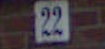

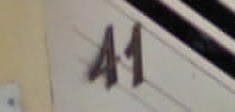

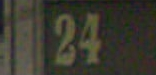

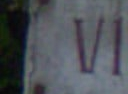

Displaying images in:  extra


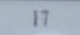

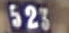

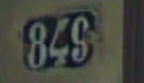

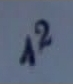

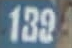

Displaying images in:  test


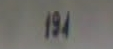

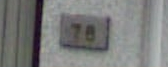

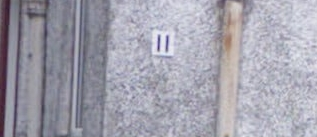

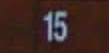

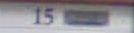

In [4]:
# Visualise a sample of each label
def display_images(folder, samples_per_label):
    print ('Displaying images in: ', folder)
    folder_path = os.path.join(data_root, folder)
    images = os.listdir(folder_path)
    random.shuffle(images)
    for image in images[:samples_per_label]:
        display(Image(filename=os.path.join(folder_path, image), width=80.0, height=80.0))
            
display_images('train', 5)
display_images('extra', 5)
display_images('test', 5)

In [18]:
# using https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader to convert .mat files to .csv
import digitStructMatToCsv
def matToCsv(sourceMat, destCsv, force=False):
    if (os.path.isfile(destCsv)):
        print (sourceMat + " already converted to " + destCsv)
    else:
        csvFile = open(destCsv, 'w')
        digitStructMatToCsv.writeToCsvFile(sourceMat, csvFile)
        csvFile.close()
        print (sourceMat + " converted to " + destCsv)

# Convert
matToCsv(os.path.join(data_root, "train", "digitStruct.mat"),
         os.path.join(data_root, "train", "digitStruct.csv"))
matToCsv(os.path.join(data_root, "test", "digitStruct.mat"),
         os.path.join(data_root, "test", "digitStruct.csv"))
matToCsv(os.path.join(data_root, "extra", "digitStruct.mat"),
         os.path.join(data_root, "extra", "digitStruct.csv"))

# Display 
svhn_train_digit_info = pd.read_csv(os.path.join(data_root, "train", "digitStruct.csv"))
svhn_test_digit_info = pd.read_csv(os.path.join(data_root, "test", "digitStruct.csv"))
svhn_extra_digit_info = pd.read_csv(os.path.join(data_root, "extra", "digitStruct.csv"))
display(svhn_train_digit_info.head())
display(svhn_test_digit_info.head())
display(svhn_extra_digit_info.head())

Number of image files: 33402
./dataset/svhn/train/digitStruct.mat converted to ./dataset/svhn/train/digitStruct.csv
Number of image files: 13068
./dataset/svhn/test/digitStruct.mat converted to ./dataset/svhn/test/digitStruct.csv
Number of image files: 202353
./dataset/svhn/extra/digitStruct.mat converted to ./dataset/svhn/extra/digitStruct.csv


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
1,1.png,9,323,81,96,219
2,2.png,2,77,29,23,32
3,2.png,3,98,25,26,32
4,3.png,2,17,5,8,15


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,5,43,7,19,30
1,2.png,2,99,5,14,23
2,2.png,1,114,8,8,23
3,2.png,10,121,6,12,23
4,3.png,6,61,6,11,16


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,4,24,70,38,56
1,1.png,7,55,41,36,56
2,1.png,8,79,23,47,56
3,2.png,7,32,13,94,203
4,2.png,1,143,33,38,203


In [19]:
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [20]:
def create_svhn_metadata(image_folder,dataframe):
    df = pd.DataFrame(columns=('filename', 'value', 'digits', 'length', 'width', 'height','box'))
    current_image_file = ""
    digits = []
    left = top = 999999
    right = bottom = 0
    for i, row in dataframe.iterrows():
        
        if current_image_file != row['FileName']:
            if len(digits) > 0:
                img = novice.open(os.path.join(image_folder,current_image_file))
                df.loc[len(df)] = [current_image_file ,int("".join(str(x) for x in digits)), digits, len(digits), img.width, img.height,[left,top,right,bottom]]
            current_image_file = row['FileName']
            digits = []
            left = top = 999999
            right = bottom = 0
            
        # Since 0 are encoded as 10 in the mat and csv. we substite 10 with 0    
        digit = 0 if row['DigitLabel'] == 10 else row['DigitLabel']
        # The street number surrounding crop box
        left = min(row['Left'],left)
        top = min(row['Top'],top)
        right = max(row['Left'] + row['Width'],right)
        bottom = max(row['Top'] + row['Height'],bottom)
        digits.append(digit)

    return df

In [23]:
svhn_train_df = create_svhn_metadata(os.path.join(data_root, "train"),svhn_train_digit_info)
svhn_test_df = create_svhn_metadata(os.path.join(data_root, "test"),svhn_test_digit_info)
svhn_extra_df = create_svhn_metadata(os.path.join(data_root, "extra"),svhn_extra_digit_info)

saveAsPickle(svhn_train_df, os.path.join(data_root, "train", "digitStruct.dataframe"))
saveAsPickle(svhn_test_df, os.path.join(data_root, "test", "digitStruct.dataframe"))
saveAsPickle(svhn_extra_df, os.path.join(data_root, "extra", "digitStruct.dataframe"))

KeyboardInterrupt: 

## Network

In [ ]:
def accuracy(predictions, labels):
    predictions = np.transpose(predictions, (1, 0, 2))
    global_acc = 100.0 * np.mean(np.prod(np.argmax(predictions, 2) == np.argmax(labels, 2), 1))
    individual_acc = 100 * np.mean(np.argmax(predictions, 2) == np.argmax(labels, 2), 0)
    return [global_acc, individual_acc]

In [ ]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64
image_size = (28, 56)
num_outputs = 5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_dataset = tf.placeholder(tf.float32, shape=(None, image_size[0], image_size[1], num_channels), name='data')
    tf_labels  = tf.placeholder(tf.float32, shape=(None, num_outputs, num_labels), name='labels')
    tf_learning_rate = tf.placeholder(tf.float32, name='learning_rate')
  
    tf.summary.image('inputs', tf_dataset)
    # Variables.
    ## First convolutional layer
    with tf.name_scope('conv1/'):
        with tf.variable_scope('conv1/'):
            conv1_weights = tf.get_variable('conv1_w', shape=[patch_size, patch_size, num_channels, depth],
                                            initializer=tf.contrib.layers.xavier_initializer())
            conv1_biases = tf.get_variable('conv1_b', shape=[depth],
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', conv1_weights)
        tf.summary.histogram('bias', conv1_biases)
    
    ## Second convolutional layer
    with tf.name_scope('conv2/'):
        with tf.variable_scope('conv2/'):
            conv2_weights = tf.get_variable('conv2_w', shape=[patch_size, patch_size, depth, depth],
                                           initializer=tf.contrib.layers.xavier_initializer())
            conv2_biases = tf.get_variable('conv2_b', shape=[depth],
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', conv2_weights)
        tf.summary.histogram('bias', conv2_biases)
    
    ## fully connected layer
    with tf.name_scope('fc1/'):
        with tf.variable_scope('fc1/'):
            fc1_weights = tf.get_variable('fc1/fc1_w', shape=[image_size[0] // 4 * image_size[1] // 4 * depth, num_hidden],
                                         initializer=tf.contrib.layers.xavier_initializer())
            fc1_biases = tf.get_variable('fc1/fc1_b', shape=[num_hidden],
                                         initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', fc1_weights)
        tf.summary.histogram('bias', fc1_biases)
                                
    with tf.name_scope('fc2/'):
        with tf.variable_scope('fc2/'):
            fc2_weights = tf.get_variable('fc2_w', shape=[num_hidden, num_hidden],
                                         initializer=tf.contrib.layers.xavier_initializer())
            fc2_biases = tf.get_variable('fc2_b', shape=[num_hidden],
                                         initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', fc2_weights)
        tf.summary.histogram('bias', fc2_biases)
    
    ## softmax
    with tf.name_scope('digit1/'):
        with tf.variable_scope('digit1/'):
            softmax1_weights = tf.get_variable('digit1_w', shape=[num_hidden, num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            softmax1_biases = tf.get_variable('digit1_b', shape=[num_labels],
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', softmax1_weights)
        tf.summary.histogram('bias', softmax1_biases)
    
    with tf.name_scope('digit2/'):
        with tf.variable_scope('digit2/'):
            softmax2_weights = tf.get_variable('digit2_w', shape=[num_hidden, num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            softmax2_biases = tf.get_variable('digit2_b', shape=[num_labels],
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', softmax2_weights)
        tf.summary.histogram('bias', softmax2_biases)
    
    with tf.name_scope('digit3/'):
        with tf.variable_scope('digit3/'):
            softmax3_weights = tf.get_variable('digit3_w', shape=[num_hidden, num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            softmax3_biases = tf.get_variable('digit3_b', shape=[num_labels],
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', softmax3_weights)
        tf.summary.histogram('bias', softmax3_biases)
    
    with tf.name_scope('digit4/'):
        with tf.variable_scope('digit4/'):
            softmax4_weights = tf.get_variable('digit4_w', shape=[num_hidden, num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            softmax4_biases = tf.get_variable('digit4_b', shape=[num_labels],
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', softmax4_weights)
        tf.summary.histogram('bias', softmax4_biases)
    
    with tf.name_scope('digit5/'):
        with tf.variable_scope('digit5/'):
            softmax5_weights = tf.get_variable('digit5_w', shape=[num_hidden, num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            softmax5_biases = tf.get_variable('digit5_b', shape=[num_labels],
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1))

        tf.summary.histogram('weights', softmax5_weights)
        tf.summary.histogram('bias', softmax5_biases)
  
    # Model.
    def model(data):
        # first conv
        with tf.name_scope('conv1/'):
            conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
            conv   = tf.nn.relu(conv + conv1_biases)
            for i in range(depth):
                tf.summary.image(f'conv{i}', tf.reshape(conv[:, :, :, i], [-1, 28, 56, 1]))
            hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        with tf.name_scope('conv2/'):
            conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 1, 1, 1], padding='SAME')
            conv   = tf.nn.relu(conv + conv2_biases)
            hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        with tf.name_scope('flatten/'):
            shape   = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])

        # fc1
        with tf.name_scope('fc1/'):
            hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # fc2
        with tf.name_scope('fc2/'):
            hidden = tf.nn.relu(tf.matmul(hidden, fc2_weights) + fc2_biases)
        
        # classifiers
        with tf.name_scope('digit1/'):
            classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        with tf.name_scope('digit2/'):
            classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        with tf.name_scope('digit3/'):
            classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        with tf.name_scope('digit4/'):
            classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        with tf.name_scope('digit5/'):
            classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits = model(tf_dataset)
    
    total_loss = 0
    for i in range(len(logits)):
        with tf.name_scope(f'digit{i+1}/'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf_labels[:, i], logits=logits[i]))
            tf.summary.scalar('loss', loss)
            total_loss += loss
    tf.summary.scalar('total_loss', total_loss)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(tf_learning_rate)
    grads_and_vars = optimizer.compute_gradients(total_loss)
    minimize = optimizer.minimize(total_loss)
    
    # Gradient norm summary
    for g,v in grads_and_vars:
        if 'fc2_w' in v.name:
            with tf.name_scope('gradients'):
                tf_last_grad_norm = tf.sqrt(tf.reduce_mean(g**2))
                tf.summary.scalar('grad_norm', tf_last_grad_norm)
                break
  
    merged = tf.summary.merge_all()
    # Predictions
    def prediction(logits):
        prediction = []
        for i in range(len(logits)):
            with tf.name_scope(f'prediction{i+1}'):
                prediction.append(tf.nn.softmax(logits[i]))
        return tf.stack(prediction)
    
    predictions = prediction(logits)

In [ ]:
def printStatistics(dataset ,loss, accuracies):
    print(f'\t{dataset} loss: {loss}')
    print(f'\t{dataset} accuracy: global - {accuracies[0]:.2f}% --- average - {np.mean(accuracies[1]):.2f}%')
    for i in range(len(accuracies[1])):
        print(f'\tDigit{i}: {accuracies[1][i]:.2f}%')

In [ ]:
num_steps = 7001
train_dir = ''
valid_dir = ''

with tf.Session(graph=graph) as session:
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    
    train_writer = tf.summary.FileWriter(train_dir, session.graph)
    valid_writer = tf.summary.FileWriter(valid_dir, session.graph)
    
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_dataset: batch_data, tf_labels: batch_labels, tf_learning_rate: 0.05}
        _, t_loss, t_predictions, t_summary = session.run(
            [minimize, total_loss, predictions, merged], feed_dict=feed_dict)

        if (step % 100 == 0):
            print(f'step {step}:')
            train_writer.add_summary(t_summary, step)
            t_accuracies = accuracy(t_predictions, batch_labels)
            printStatistics('Train', t_loss, t_accuracies)

            # Validation
            feed_dict = {tf_dataset: valid_dataset, tf_labels: valid_labels}
            v_loss, v_predictions, v_summary = session.run([total_loss, predictions, merged], feed_dict=feed_dict)
            valid_writer.add_summary(v_summary, step)
            v_accuracies = accuracy(v_predictions, valid_labels)
            printStatistics('Validation', v_loss, v_accuracies)
                
            
    # Test
    feed_dict = {tf_dataset: test_dataset, tf_labels: test_labels}
    test_loss, test_predictions = session.run([total_loss, predictions], feed_dict=feed_dict)
    test_accuracies = accuracy(test_predictions, test_labels)
    printStatistics('Test', test_loss, test_accuracies)